<a href="https://colab.research.google.com/github/Jan-Piotraschke/fachkurs_systembiology/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip3 install scipy pandas numpy matplotlib
#!pip3 install voila  # Voilà works with any Jupyter kernel (C++, Python, Julia)
from scipy.integrate import odeint
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets  # make this notebook interactive


In [23]:
# parameters
k_RL = 2 * 10 ** 6
k_RLm = 10 ** -2
k_Rs = 4
k_Rd0 = 4 * 4 ** -4
k_Rd1 = k_Rd0 * 10
k_G1 = 1
k_Ga = 10 ** -5

Gt = 10 ** 4  # total number of G proteins per cell



In [27]:
def solve_ode_system(current_state, t, k_Gd, L) -> list:
    """

    :param current_state: current state of the ODE system
    :param t: time of simulation
    :param parameter: rate constant for G protein deactivation
    :return: solution of the ODE System
    """
    R, RL, G, Ga = current_state

    # algebraic equations:
    Gd = Gt - G - Ga  # Galpha-GDP
    Gbg = Gt - G  # free Gbetagamma

    # the ODEs ahead:
    dR_dt = -k_RL*L*R + k_RLm*RL - k_Rd0*R + k_Rs
    dRL_dt = k_RL*L*R - k_RLm*RL - k_Rd1*RL
    dG_dt = -k_Ga*RL*G + k_G1*Gd*Gbg
    dGa_dt = k_Ga*RL*G - k_Gd*Ga

    return [dR_dt, dRL_dt, dG_dt, dGa_dt]



In [52]:
time = np.arange(0, 600, 0.01)

# initial values
# TODO: dummy values -> didn't found the real values yet
R_0 = 5000  # free receptor
RL_0 = 500  # receptor bound to ligand
G_0 = 500  # inactive heterotrimeric G protein
Ga_0 = 500  # active Galpha-GTP
S0 = [R_0, RL_0, G_0, Ga_0]

# variable rate constant for G protein deactivation
k_Gd = 0.004   # 0.11  # 0.004
L_alpha =  10 ** -6  # alpha-factor -> 1 uM
solution = pd.DataFrame(odeint(solve_ode_system, S0, time, args=(k_Gd, L_alpha)), columns=['R', 'RL', 'G', 'Ga'])

dose_response = {}
for L_var in [0.03, 0.1, 0.2, 0.6, 1, 10, 100, 1000]:  # nM alpha-factor 
    data = pd.DataFrame(odeint(solve_ode_system, S0, time, args=(k_Gd, L_var*10**-3)), columns=['R', 'RL', 'G', 'Ga'])
    dose_response[L_var] = data


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


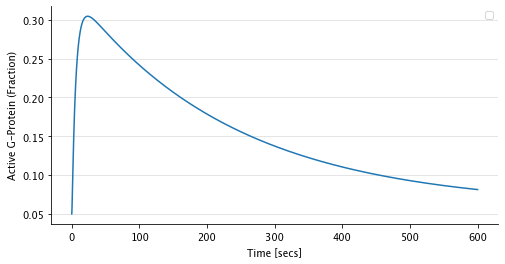

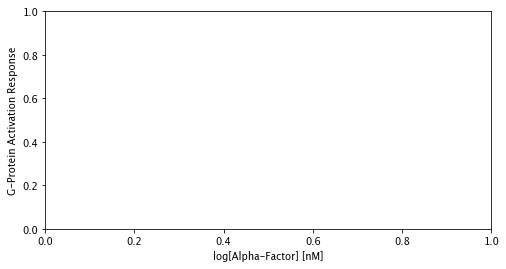

In [47]:
fig, ax = plt.subplots(figsize=(8, 4)) #, ncols=2)

# choose the style of the plot
# print(plt.style.available)
# plt.style.use('classic')
ax.set_xlabel("Time [secs]")
ax.set_ylabel("Active G-Protein (Fraction)")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(time, solution["Ga"]/Gt)  # Fig. 5A from the paper 
ax.legend()

# plt.legend(loc=(1.1,0.5), frameon=False)

# ax.xaxis.set_ticks([0,60,120])
# ax.set_xlim(0,200)
# ax.set_ylim(0,5000)
ax.yaxis.grid(alpha=0.4)

# plt.savefig('GA_Deaths_40days.png', dpi=600, bbox_inches='tight')
fig1, ax1 = plt.subplots(figsize=(8, 4)) #, ncols=2)
ax1.set_xlabel('log[Alpha-Factor] [nM]')
ax1.set_ylabel('G-Protein Activation Response')

plt.show()